In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('drive/My Drive/redes_neurais_time_series/ts_hr_feb_2020.csv.zip', parse_dates=['date'])

In [5]:
data.head()

,date,sales_value
0,2020-02-01 00:00:00,28.60
1,2020-02-01 01:00:00,122.84
2,2020-02-01 02:00:00,112.87
3,2020-02-01 03:00:00,357.20
4,2020-02-01 04:00:00,642.56


In [7]:
?tf.keras.layers.Conv1D

In [ ]:
# filtros -quantas convoluções faremos (numero de filtros em convolução)
#kernel - comprimento da janela de convolução quantos elementos vai (quantos elementos em cada convolução)
#stride - quantos passos na hora de deslizar a convolução
# Input - 3 dimensões (numero de linhas, numero de passos da serie temporal, numero de feature para cada passo)
# batch size aprende sozinho
# utilizar as ultimas 24 horas para prever a proximas 24 horas
# dimensão 1 que é só o valor das vendas
# 10 filtros aprendender 10 transformações
# media movel de 4 periodos por exemplo 
#tamanho 3 de numero de elementos que vai realizar a convulução
# resultando em 10 series de 22 elementos
#flatten achata vetoriza
# muda pra densa
# faz a previsão para as ultimas 24 h

In [9]:
numerical_i = tf.keras.layers.Input((24,1))
numerical=tf.keras.layers.Conv1D(10,3)(numerical_i)
numerical = tf.keras.layers.Flatten()(numerical)
dense = tf.keras.layers.Dense(200,'relu')(numerical)
out = tf.keras.layers.Dense(24, 'relu')(dense)
mdl = tf.keras.Model(numerical_i, out)
mdl.compile('adam', 'mae')
mdl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 10)            40        
_________________________________________________________________
flatten_1 (Flatten)          (None, 220)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               44200     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                4824      
Total params: 49,064
Trainable params: 49,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#dividir validação e teste
# pega o ultimo domigo do mes de fevereiro

In [10]:
last_sunday = pd.to_datetime("2020-02-23")
train = data[data['date'] < last_sunday]
val = data[data['date'] >= last_sunday]

In [15]:
train.shape

(527, 2)

In [23]:
# nosso x serão as 24 horas anteriores ao momento atual features
# horizonte prever os 24 próximos períodos
# f 24 valores 
# h 24 valores nos proximos 24 periodos
l = 24
h = 24
X = []
Y = []
for i in range(l, train.shape[0] - h):
  f = train.iloc[i-l: i]['sales_value'].values
  y = train.iloc[i:i+h]['sales_value'].values
  X.append(f)
  Y.append(y)
X = np.array(X)
Y = np.array(Y)
X = np.expand_dims(X, -1)

In [12]:
f

array([  28.6 ,  122.84,  112.87,  357.2 ,  642.56,  381.66,  477.52,
       1764.59, 1824.88, 1910.25, 2093.19, 2644.12, 2920.64, 2059.13,
       3150.54, 2262.22, 1830.67, 2345.46, 1571.72, 2075.09, 2044.07,
       2175.01, 1279.93,  559.54])

In [13]:
y

array([ 268.56,  338.28,  201.82,  374.48, 1278.5 ,  742.09, 1934.04,
       1287.22, 1684.18, 2070.93, 3075.85, 2715.93, 2597.4 , 2404.74,
       2197.92, 2208.32, 3137.58, 2099.34, 1986.22, 2535.43, 3002.85,
       1887.64, 1302.54,  362.01])

In [24]:
mdl.fit(X, Y, batch_size=1, shuffle=True, epochs=5)

Epoch 1/5
479/479 [==============================] - 1s 1ms/step - loss: 480.2010
Epoch 2/5
479/479 [==============================] - 1s 1ms/step - loss: 474.1601
Epoch 3/5
479/479 [==============================] - 1s 1ms/step - loss: 475.7120
Epoch 4/5
479/479 [==============================] - 1s 1ms/step - loss: 465.7161
Epoch 5/5
479/479 [==============================] - 1s 1ms/step - loss: 460.6497


In [22]:
l = 24
h = 24
Xv = []
Yv = []
for i in range(l, val.shape[0] - h):
  f = val.iloc[i-l: i]['sales_value'].values
  y = val.iloc[i:i+h]['sales_value'].values
  Xv.append(f)
  Yv.append(y)
Xv = np.array(Xv)
Yv = np.array(Yv)
Xv = np.expand_dims(Xv, -1)

In [25]:
p = mdl.predict(Xv)

In [26]:
Yv.shape

(121, 24)

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Yv, p)

469.0558806787969

In [28]:
print(Y)

[[ 268.56  338.28  201.82 ... 1887.64 1302.54  362.01]
 [ 338.28  201.82  374.48 ... 1302.54  362.01  578.65]
 [ 201.82  374.48 1278.5  ...  362.01  578.65  292.1 ]
 ...
 [1307.42  739.15  420.42 ... 1488.59 1558.14 1783.28]
 [ 739.15  420.42  479.9  ... 1558.14 1783.28 1161.9 ]
 [ 420.42  479.9   236.64 ... 1783.28 1161.9  1293.98]]


In [42]:
print(len(np.median(Y, axis=0)))

24


In [50]:
print(np.median(Y[:, 1]))

1864.3400000000008


In [32]:
# pega a mediana dos Y de treino
p_base = np.ones(Yv.shape)*np.median(Y, axis=0)

In [33]:
print(p_base)

[[1864.34 1864.34 1864.34 ... 1816.54 1807.54 1807.54]
 [1864.34 1864.34 1864.34 ... 1816.54 1807.54 1807.54]
 [1864.34 1864.34 1864.34 ... 1816.54 1807.54 1807.54]
 ...
 [1864.34 1864.34 1864.34 ... 1816.54 1807.54 1807.54]
 [1864.34 1864.34 1864.34 ... 1816.54 1807.54 1807.54]
 [1864.34 1864.34 1864.34 ... 1816.54 1807.54 1807.54]]


In [51]:
mean_absolute_error(Yv, p_base)

829.0155612947652

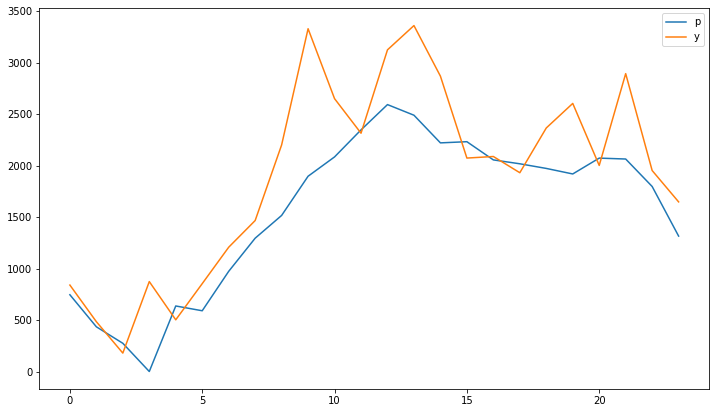

In [52]:
pd.DataFrame({'p':p[71, :], 'y':Yv[71, :]}).plot(figsize=(12,7))